In [11]:
# import libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import SGD, Adam

%matplotlib inline

In [12]:
# import dataset
from sklearn.datasets import load_digits
mnist = load_digits()
data = mnist.images.astype(np.float32)
labels = mnist.target.astype(np.int32)

In [13]:
# define neural network
class CNNNumberClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # input channel is 1 since image is grayscale
        # alternating from conv2d, relu, and batch norm
        L = [
            torch.nn.Conv2d(1, 32, kernel_size=2), 
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 64, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64, 128, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128, 256, kernel_size=2), 
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256)
        ]
        
        # initialize network
        self.network = torch.nn.Sequential(*L)
        
        # classify numbers between 0-9
        self.classifier = torch.nn.Linear(256, 10)
        
    def forward(self, x):
        z = self.network(x)
        z = z.mean([2,3])
        return self.classifier(z)

In [14]:
# define dataset class
from torch.utils.data import Dataset
class DigitsDataset(Dataset):
    def __init__(self, features, labels):
        self.data = []
        for x,y in zip(features, labels): 
            self.data.append((torch.tensor(x, dtype=torch.float32).unsqueeze(0),y))
        
    def __len__(self):
        return len(self.data)

                             
    def __getitem__(self, idx):
        return self.data[idx]
                         

In [15]:
# process data into tensors
data = []
for image_data in mnist.images:
    data.append(torch.tensor(image_data, dtype=torch.float64))

In [20]:
def accuracy(outputs, labels):
    outputs_idx = outputs.max(1)[1].type_as(labels)
    return outputs_idx.eq(labels).float().mean()

In [21]:
# train the model
model = CNNNumberClassifier()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# split dataset into train (80%)
train_features, temp_features, train_labels, temp_labels = train_test_split(data, labels,
                                                                   random_state=42, test_size=.2)

# use remaining 20% of dataset and split it into validation (10%) and test datasets (10%)
valid_features, test_features, valid_labels, test_labels = train_test_split(temp_features, temp_labels,
                                                                    random_state=42, test_size=.5)

# create dataset classes for train and valid
train_data = DigitsDataset(train_features, train_labels)
valid_data = DigitsDataset(valid_features, valid_labels)

# place training data inside of dataloader
data_loader_train = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
data_loader_valid = DataLoader(valid_data, batch_size=32, shuffle=True, drop_last=True)

# optimizer
optimizer = SGD(model.parameters(), lr=.001, momentum=.9, weight_decay=.0001)

# train the network epoch amount of times
epochs = 200

train_loss = []
valid_acc = []

for i in range(epochs):    
    # training
    model.train()
    curr_loss = []
    for x, y in data_loader_train:
        optimizer.zero_grad()
        
        output = model(x)
        
        loss = F.cross_entropy(output, y.long())
        loss.backward()
        
        curr_loss.append(loss)
                
        optimizer.step()
        
    # store average loss for the current epoch
    avg_loss = torch.mean(torch.tensor(curr_loss)).item()    
    train_loss.append(avg_loss)
    
    # validation
    model.eval()
    curr_acc = []
    for x, y in data_loader_valid:
        # predict data 
        outputs = model(x)

        # compute accuracy 
        acc = accuracy(outputs, y)
        
        curr_acc.append(acc)
        
    # store average validation accuracy for the current epoch
    avg_acc = torch.mean(torch.tensor(curr_acc)).item()
    valid_acc.append(avg_acc)



/var/folders/1t/51hvg6f90_s_pk5sxz5549b00000gn/T/ipykernel_39670/3623797631.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data.append((torch.tensor(x, dtype=torch.float32).unsqueeze(0),y))


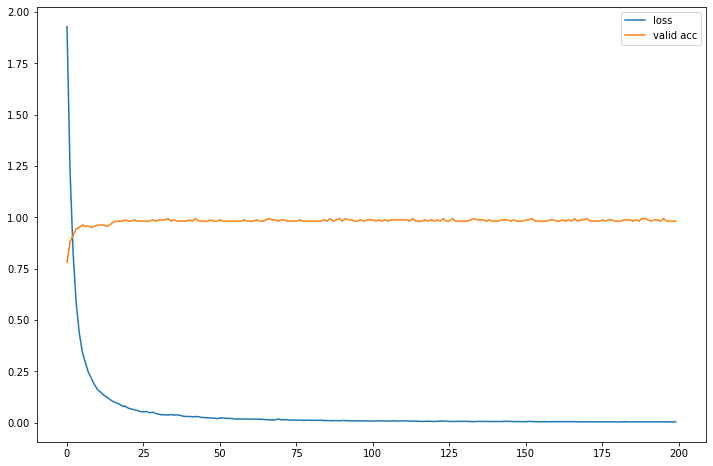

In [22]:
# plot training and validation losses 
plt.figure(figsize=(12, 8))
plt.plot([i for i in range(epochs)], train_loss, label="loss")
plt.plot([i for i in range(epochs)], valid_acc, label='valid acc')
plt.legend()
plt.show()

In [23]:
# run model on testing data and report accuracy
test_data = DigitsDataset(test_features, test_labels)
data_loader_test = DataLoader(test_data, batch_size=1)

model.eval()
test_accuracies = []
for x, y in data_loader_test:
    # predict data 
    outputs = model(x)

    # compute accuracy 
    acc = accuracy(outputs, y)
            
    # append accuracy to list
    test_accuracies.append(acc.item())
    
print("accuracy on test: ", str(torch.mean(torch.tensor(test_accuracies)).item()))

accuracy on test:  1.0


/var/folders/1t/51hvg6f90_s_pk5sxz5549b00000gn/T/ipykernel_39670/3623797631.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data.append((torch.tensor(x, dtype=torch.float32).unsqueeze(0),y))
